In [1]:
# Function to generate data sets
import numpy as np
from scipy.linalg import block_diag

def dataset(N_dim=2, N_points=10000, cor=0.0, offset=0., type="full", blocks=None, constant=None):
    """Generate multivariate normal data"""
    if blocks is None:
        blocks = [int(np.floor(N_dim/2)), int(np.ceil(N_dim/2))]
        
    if type == "block":
        # Split correlations into independent blocks
        cov = block_diag(*[np.full((n,n), cor) for n in blocks])
    elif type == "antiblock":
        # Split correlations into identity blocks with correlation between them
        covs = []
        i = 0
        for blk_i in blocks:
            j = 0
            covs.append([])
            for blk_j in blocks:
                if i == j:
                    covs[-1].append(np.eye(blocks[i]))
                else:
                    covs[-1].append(np.full((blocks[i], blocks[j]), 1./max(blocks[i], blocks[j])))
                j += 1
            i += 1
            
        cov = np.block(covs)
    elif type == "diagblock":
        # Split correlations into identity blocks with diagonal correlation between them
        covs = []
        i = 0
        for blk_i in blocks:
            j = 0
            covs.append([])
            for blk_j in blocks:
                if i == j:
                    covs[-1].append(np.eye(blocks[i]))
                else:
                    covs[-1].append(np.eye(blocks[i], blocks[j]) * cor)
                j += 1
            i += 1
            
        cov = np.block(covs)
    elif type == "linear":
        # Linearly decreasing correlation to neighbours
        cov = np.zeros((N_dim,N_dim))
        for i, c in enumerate(np.linspace(cor, -cor/2, N_dim-1)):
            cov += np.diag([c]*(N_dim-(i+1)), i+1)
        cov += cov.T
    elif type == "exp":
        # Exponentially decreasing correlation to neighbours
        cov = np.zeros((N_dim,N_dim))
        cors = cor ** (np.arange(N_dim-1) + 1)
        for i, c in enumerate(cors):
            cov += np.diag([c]*(N_dim-(i+1)), i+1)
        cov += cov.T
    elif type == "full":
        # Full identical correlation
        cov = np.full((N_dim,N_dim), cor)
    np.fill_diagonal(cov, 1)
    
    # Add constant part of covariance
    if constant is not None:
        cov += constant
    
    rng = np.random.default_rng()
    return rng.multivariate_normal(mean=np.zeros(N_dim), cov=cov, size=N_points) + offset

In [2]:
# Default data sets

N_DIM = 10
N_POINTS = 1000000
def default_sets(N_dim=N_DIM, N_points=N_POINTS, type="full", blocks=None, remove={}, constant=None):
    sets = {
        "Uncorr.": (N_dim, N_points, 0.0,  0.0),
        "Corr.50": (N_dim, N_points, 0.5,  0.0),
        "Corr.90": (N_dim, N_points, 0.9,  0.0),
        "Corr.99": (N_dim, N_points, 0.99, 0.0),
    }
    for key in remove:
        del sets[key]
    keys = list(sets.keys())
    for k in keys:
        sets[k] = dataset(*sets[k], type=type, blocks=blocks, constant=constant)
    return sets

In [3]:
#print(default_sets(type="exp"))

In [4]:
from scipy.stats import special_ortho_group

def generate_covariance(identity_blocks=[1]*N_DIM):
    """Generate a random covariance matrix with the given sizes of block identity matrices on the diagonal."""
    
    ndim = np.sum(identity_blocks)
    B = np.eye(ndim)
    i = 0
    # random rotations
    rot_gen = special_ortho_group(ndim)
    for k in identity_blocks:
        # random rotation matrix
        R = rot_gen.rvs()
        B[:,i:i+k] = R @ B[:,i:i+k]
        i += k
    
    return B.T @ B

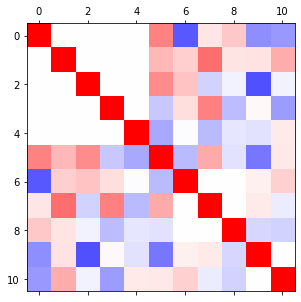

In [5]:
from matplotlib import pyplot as plt
C = generate_covariance([5,1,3,2])
v_max = np.max(np.abs(C))
plt.matshow(C, vmin=-v_max, vmax=v_max, cmap="bwr", )